# Set-up
## Imports, load the dataset

In [357]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize
import tensorflow as tf
import os

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
diabetes.DESCR

'Diabetes dataset\n================\n\nNotes\n-----\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\nData Set Characteristics:\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attributes:\n    :Age:\n    :Sex:\n    :Body mass index:\n    :Average blood pressure:\n    :S1:\n    :S2:\n    :S3:\n    :S4:\n    :S5:\n    :S6:\n\nNote: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).\n\nSource URL:\nhttp://www4.stat.ncsu.edu/~boos/var.select/diabetes.html\n\nFor more information see:\nBradley Efr

## Split the dataset into training and test

test size: 132


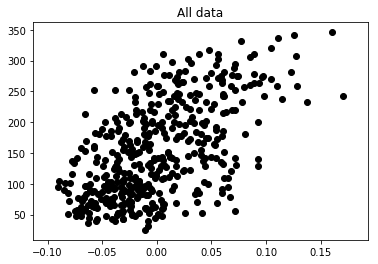

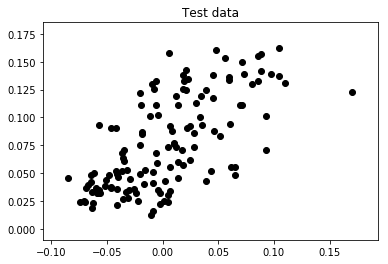

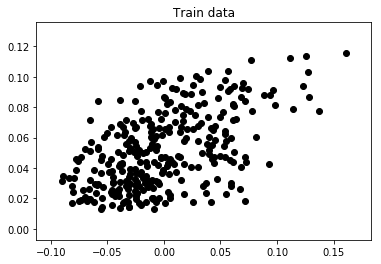

In [358]:
# Use only one feature
shuffle_ids = np.random.permutation(diabetes.data.shape[0])
diabetes_X = diabetes.data[shuffle_ids, np.newaxis, 2]
diabetes_y = diabetes.target[shuffle_ids]
test_size  = int(diabetes.data.shape[0] * 0.3)
print('test size: ' + str(test_size))

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-test_size]
diabetes_X_test  = diabetes_X[-test_size:]

# Split the targets into training/testing sets
diabetes_y_train = normalize(diabetes_y[:-test_size, np.newaxis], axis=0)
diabetes_y_test  = normalize(diabetes_y[-test_size:, np.newaxis], axis=0)

# Plot data
plt.scatter(diabetes.data[:, np.newaxis, 2], diabetes.target,  color='black')
plt.title('All data')
plt.show()

plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.title('Test data')
plt.show()

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.title('Train data')
plt.show()

## Model Space

In [359]:
# Create spaces of W and b
step    = 0.01
W_space = np.arange(-1, 2, step)
b_space = np.arange(-0.05 , 0.18, step/5)
costs   = np.zeros([len(W_space), len(b_space)])

# Compute the loss function for each
for i in range(len(W_space)):
    for j in range(len(b_space)):
        costs[i, j] = skl.metrics.mean_squared_error(diabetes_y_test, diabetes_X_test * W_space[i] + b_space[j])
        if i % 100 == 0 and j % 100 == 0:
            print('Computation for W ='
                  , "{:.4f}".format(W_space[i])
                  , '; b =', "{:.4f}".format(b_space[j])
                  , '; loss =', "{:.4f}".format(costs[i, j]))

print('Done')

Computation for W = -1.0000 ; b = -0.0500 ; loss = 0.0238
Computation for W = -1.0000 ; b = 0.1500 ; loss = 0.0119
Computation for W = 0.0000 ; b = -0.0500 ; loss = 0.0177
Computation for W = 0.0000 ; b = 0.1500 ; loss = 0.0072
Computation for W = 1.0000 ; b = -0.0500 ; loss = 0.0165
Computation for W = 1.0000 ; b = 0.1500 ; loss = 0.0073
Done


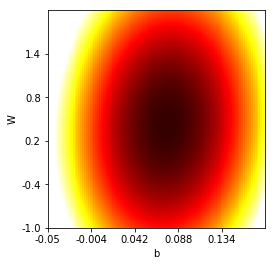

In [387]:
def loss_with_path(path, fig=plt):
    ticks_size = 5
    
    # Heatmap
    fig.imshow(costs, cmap='hot', norm = Normalize(vmin=0, vmax=0.015), interpolation='nearest', extent=[0, ticks_size, 0, ticks_size])
    fig.xlabel('b'); plt.xticks(range(ticks_size), b_space[np.arange(0, len(b_space), int(len(b_space) / ticks_size))])
    fig.ylabel('W'); plt.yticks(range(ticks_size), W_space[np.arange(0, len(W_space), int(len(W_space) / ticks_size))])
    
#     # Legend
#     fig.text(0.3, 4.3, 'min=' + "{:.4f}".format(np.min(costs)) + '\nmax=' + "{:.4f}".format(np.max(costs)), bbox={'facecolor': 'white', 'pad': 10})
    
    # Path
    path_x = path[:, 0]
    path_y = path[:, 1]
    
    map_space = lambda s: [np.min(s), ticks_size / (np.max(s) - np.min(s))]
    x_min, x_scale = map_space(b_space)
    y_min, y_scale = map_space(W_space)
    
    path_x_mapped = (path_x - x_min) * x_scale
    path_y_mapped = (path_y - y_min) * y_scale
        
    fig.plot(path_x_mapped, path_y_mapped, marker='o', label='Gradient Descent Path')
    fig.ylim([0,ticks_size])
    fig.xlim([0,ticks_size])

loss_with_path(np.array([[]]).reshape(0, 2))
plt.show()

# Training
## Define the linear regression model

In [388]:
# Parameters
learning_rate   = 0.1
n_samples       = diabetes_X_train.shape[0]

tf.reset_default_graph()

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.get_variable("weight", [1, 1], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b = tf.get_variable("bias", [1], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.losses.mean_squared_error(Y, pred)

# Summaries
tf.summary.scalar('loss', cost)
tf.summary.scalar('W', tf.reduce_max(W))
tf.summary.scalar('b', tf.reduce_max(b))
summaries = tf.summary.merge_all()

# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

## Training

In [ ]:
# Constants, create necessary dirs if they don't exist
training_epochs = 100
display_step    = 1
gradient_trace  = 10

log_dir_base  = './log'
plot_dir_base = './plot'

if not os.path.exists(plot_dir_base): os.makedirs(plot_dir_base)
if not os.path.exists(log_dir_base ): os.makedirs(log_dir_base)
    
log_dir  = log_dir_base + '/' + str(len(os.listdir(log_dir_base)))
plot_dir = plot_dir_base + '/' + str(len(os.listdir(plot_dir_base)))

if not os.path.exists(plot_dir): os.makedirs(plot_dir)

train_writer  = tf.summary.FileWriter(log_dir)

gradient_log = np.zeros([training_epochs, 2])

# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
        
        # Display logs per epoch step
        if epoch % display_step == 0:
            # Write summaries for tensorboard
            sums, c, train_pred, W_res, b_res = sess.run([summaries, cost, pred, W, b], feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
            train_writer.add_summary(sums, epoch)
            train_writer.flush()
            
            # Write gradient log
            gradient_log[epoch, 0] = b_res
            gradient_log[epoch, 1] = W_res
            
            # Plot the model and save to file
            plt.subplot(1, 2, 1)
            plt.scatter(diabetes_X_train, diabetes_y_train, label='Original data', color='black')
            plt.plot(diabetes_X_train, train_pred, label='Fitted line')
            plt.ylim(0, 0.2)
            plt.title(str(epoch) + ': ' +
                      'W = ' + "{:.4f}".format(W_res[0, 0]) +
                      '; b = ' + "{:.4f}".format(b_res[0]) +
                      '; loss = ' + "{:.4f}".format(c))
            
            plt.subplot(1, 2, 2)
            loss_with_path(gradient_log[max(0,epoch-gradient_trace):epoch+1])

            plt.savefig(plot_dir + '/' + ('%04d' % epoch) + '.png')
            plt.clf()
            
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(c), \
                "W=", W_res, "b=", b_res)

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: diabetes_X_train, Y: diabetes_y_train})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    diabetes_y_train_pred = sess.run(pred, feed_dict={X: diabetes_X_train})
    diabetes_y_test_pred  = sess.run(pred, feed_dict={X: diabetes_X_test })
    
    plt.scatter(diabetes_X_train, diabetes_y_train, label='Original data', color='black')
    plt.plot(diabetes_X_train, diabetes_y_train_pred, label='Fitted line')
    plt.legend()
    plt.show()

    plt.scatter(diabetes_X_test, diabetes_y_test, label='Testing data', color='black')
    plt.plot(diabetes_X_test, diabetes_y_test_pred, label='Fitted line')
    plt.legend()
    plt.show()


Epoch: 0000 cost= 0.026422534 W= [[-1.0861]] b= [-0.0983]
Epoch: 0001 cost= 0.006736609 W= [[-0.9862]] b= [-0.0026]
Epoch: 0002 cost= 0.004483370 W= [[-0.8864]] b= [ 0.0816]
Epoch: 0003 cost= 0.011800296 W= [[-0.7868]] b= [ 0.1438]
Epoch: 0004 cost= 0.018742960 W= [[-0.6877]] b= [ 0.1774]
Epoch: 0005 cost= 0.020086335 W= [[-0.5891]] b= [ 0.1842]
Epoch: 0006 cost= 0.016299730 W= [[-0.4916]] b= [ 0.1708]
Epoch: 0007 cost= 0.010202460 W= [[-0.3955]] b= [ 0.1439]
Epoch: 0008 cost= 0.004616926 W= [[-0.3014]] b= [ 0.109]
Epoch: 0009 cost= 0.001396099 W= [[-0.2097]] b= [ 0.0711]
Epoch: 0010 cost= 0.001071224 W= [[-0.1213]] b= [ 0.0346]
Epoch: 0011 cost= 0.002895319 W= [[-0.0367]] b= [ 0.0038]
Epoch: 0012 cost= 0.005347372 W= [[ 0.0434]] b= [-0.018]
Epoch: 0013 cost= 0.006960702 W= [[ 0.1185]] b= [-0.0292]
Epoch: 0014 cost= 0.006997222 W= [[ 0.1881]] b= [-0.0295]
Epoch: 0015 cost= 0.005601167 W= [[ 0.2519]] b= [-0.0204]
Epoch: 0016 cost= 0.003511062 W= [[ 0.3095]] b= [-0.004]
Epoch: 0017 cost=

In [ ]:
%%bash -s "$plot_dir"
echo "Creating video at $1"
cd $1
ffmpeg -r 15 -f image2 -i %04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p video.mp4